<a href="https://colab.research.google.com/github/akshayonly/ML-Antioxidant-Antibacterial-IC50/blob/main/CDP_2021_Cytotoxicity_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Antioxidant Neural Network Models

CONTENT
- Libraries
- Data
- Data Preprocessing
    - Conversion from IC50 to pIC50
    - PaDel Descriptor
    - Data Splitting
- Antioxidant Models
    - SGD Regressor 
    - Neural Network
- Result & Conclusion

## Libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

# Data preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import r2_score, mean_squared_error

# Machine learning algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor

# Deep learning (Neural Network)
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

## Data

In [2]:
antioxidant_path = "/content/drive/MyDrive/Current-Work/ML-Chemistry-Department-2021/cytotoxicity_final.csv"

antioxidant_data = pd.read_csv(antioxidant_path)
antioxidant_data.head()

,PubChem_CID,Compound,SMILES,Heavy_Atom,Rotat_Bond,Mol_Mass,H_Donor,H_Acceptor,XLogP,Fingerprint,IC50_min,IC50_max,IC50_med
0,162350,Apigenin-6-C-glucoside,C1=CC(=CC=C1C2=CC(=O)C3=C(O2)C=C(C(=C3O)C4C(C(...,31,3,432.105652,7,10,0.2,1110000001111000001111000000000000000000000000...,50.0,50.0,50.000
1,72276,Epicatechin,C1C(C(OC2=CC(=CC(=C21)O)O)C3=CC(=C(C=C3)O)O)O,21,1,290.079041,5,6,0.4,1100000001110000001110000000000000000000000000...,25.0,184.1,25.000
2,5280863,Kaempferol,C1=CC(=CC=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O,21,1,286.047729,4,6,1.9,1100000001110000001110000000000000000000000000...,10.0,400.0,53.685
3,5280343,Quercetin,C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O,22,1,302.042664,5,7,1.5,1100000001110000001110000000000000000000000000...,2.5,177.5,23.000
4,5280804,Quercetin 3-O-glucoside,C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)OC4...,33,4,464.095490,8,12,0.4,1110000001111000001111000000000000000000000000...,10.0,10.0,10.000


## Data Preprocessing

### Conversion from IC50 to pIC50

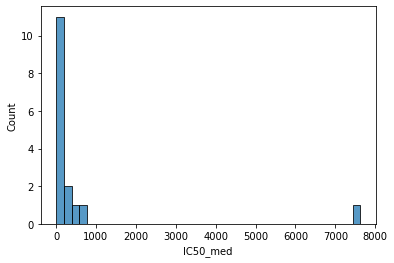

In [3]:
sns.histplot(antioxidant_data, x='IC50_med')

In [4]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

def pIC50(input, column):
    
    pIC50 = []
    for i in input[column]:
      # Converts nM to M
      molar = i*(10**-9) 
      pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    
    # Removing IC50 column
    input = input.drop(column, 1)     
        
    return input

In [5]:
antioxidant_data = pIC50(antioxidant_data, 'IC50_med')

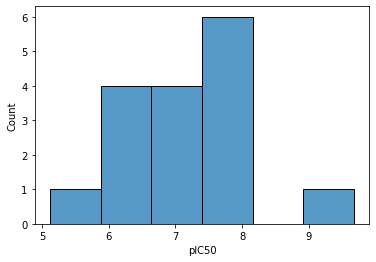

In [6]:
sns.histplot(antioxidant_data, x='pIC50')

### PaDel Descriptor

In [7]:
selection = ['SMILES','PubChem_CID']

antioxidant_data_selection = antioxidant_data[selection]

antioxidant_data_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [8]:
! cat molecule.smi | head -5

C1=CC(=CC=C1C2=CC(=O)C3=C(O2)C=C(C(=C3O)C4C(C(C(C(O4)CO)O)O)O)O)O	162350
C1C(C(OC2=CC(=CC(=C21)O)O)C3=CC(=C(C=C3)O)O)O	72276
C1=CC(=CC=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O	5280863
C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O	5280343
C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)OC4C(C(C(C(O4)CO)O)O)O)O)O	5280804


In [9]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
! unzip padel.zip
! cat padel.sh
! bash padel.sh

--2021-12-21 11:54:43--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2021-12-21 11:54:43--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M   136MB/s    in 0.2s    

2021-12-21 11:54:44 (136 MB/s) - ‘padel.zip’ saved [25768637/25768637]

--2021-12-21 11:54:44--  https://github

In [10]:
padel_desc = pd.read_csv('descriptors_output.csv')
X_padel = padel_desc.drop(columns=['Name'])
X_padel.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Data Splitting

In [11]:
y = antioxidant_data['pIC50']

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X_padel, y, test_size=0.3)

print(x_train.shape)

(11, 881)


## Antioxidant Models

### SGD Regressor

In [13]:
loss = ['squared_error'] 

penalty = ['l1', 'l2', 'elasticnet'] 

alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 

learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive'] 

eta0 = [1, 10, 100] 

param_dist = dict(loss=loss, 
                           penalty=penalty, 
                           alpha=alpha, 
                           learning_rate=learning_rate, 
                           eta0=eta0) 

param_dist

{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'eta0': [1, 10, 100],
 'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
 'loss': ['squared_error'],
 'penalty': ['l1', 'l2', 'elasticnet']}

In [14]:
sgd = SGDRegressor()

grid_search = GridSearchCV(estimator=sgd, 
                           param_grid=param_dist, 
                           scoring='neg_mean_squared_error', 
                           verbose=1, n_jobs=-1) 

grid_search_result = grid_search.fit(x_train, y_train) 
best_para = grid_search_result.best_params_

print('Best Score: ', grid_search_result.best_score_) 
print('\nBest Parameters: ', best_para)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Score:  -0.8594519045219334

Best Parameters:  {'alpha': 1000, 'eta0': 1, 'learning_rate': 'invscaling', 'loss': 'squared_error', 'penalty': 'l1'}


In [15]:
sgd = SGDRegressor(alpha=best_para['alpha'],
                   eta0=best_para['eta0'],
                   learning_rate=best_para['learning_rate'],
                   loss=best_para['loss'],
                   penalty=best_para['penalty']
                   ).fit(x_train, y_train)

### RandomForestRegressor

In [16]:
param_grid = {
    'bootstrap': [True],
    'max_features': ["auto", "sqrt", "log2"],
    'min_samples_leaf': [3, 6],
    'min_samples_split': [6, 12, 18],
    'n_estimators': [75, 150, 300]
}

In [17]:
rfr = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rfr, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           verbose=1, n_jobs=-1) 

grid_search_result = grid_search.fit(x_train, y_train) 
best_para = grid_search_result.best_params_

print('Best Score: ', grid_search_result.best_score_) 
print('\nBest Parameters: ', best_para)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Score:  -0.9244133277482606

Best Parameters:  {'bootstrap': True, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 150}


In [18]:
rfr = RandomForestRegressor(bootstrap=True,
                            n_jobs=-1,
                            max_features=best_para['max_features'],
                            min_samples_leaf=best_para['min_samples_leaf'],
                            min_samples_split=best_para['min_samples_split'],
                            n_estimators=best_para['n_estimators'])

rfr.fit(x_train, y_train)

RandomForestRegressor(max_features='log2', min_samples_leaf=6,
                      min_samples_split=6, n_estimators=150, n_jobs=-1)

### Neural Network

In [19]:
model = Sequential()

model.add(Dense(881, 
                input_dim=x_train.shape[1], 
                kernel_initializer='normal', 
                kernel_regularizer='l2',
                activation='relu', 
                name='Hidden-Layer-1'))

model.add(Dropout(0.6))

model.add(Dense(180, 
                kernel_initializer='random_normal', 
                kernel_regularizer='l2',
                activation='relu', name='Hidden-Layer-2'))

model.add(Dense(90, 
                kernel_initializer='random_normal', 
                kernel_regularizer='l2',
                activation='relu', name='Hidden-Layer-3'))

model.add(Dropout(0.2))

model.add(Dense(30, 
                kernel_initializer='random_normal', 
                kernel_regularizer='l2',  
                activation='relu', 
                name='Hidden-Layer-4'))

model.add(Dropout(0.2))

model.add(Dense(1, 
                kernel_initializer='random_normal', 
                activation='relu', 
                name='Output-Layer'))

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [21]:
model.compile(loss='mean_squared_error', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.fit(x_train, y_train, batch_size=3, epochs=150, callbacks=[callback])

Epoch 1/150
4/4 [==============================] - 1s 17ms/step - loss: 80.0790 - root_mean_squared_error: 7.5041
Epoch 2/150
4/4 [==============================] - 0s 16ms/step - loss: 79.5501 - root_mean_squared_error: 7.4858
Epoch 3/150
4/4 [==============================] - 0s 14ms/step - loss: 79.0879 - root_mean_squared_error: 7.4708
Epoch 4/150
4/4 [==============================] - 0s 11ms/step - loss: 77.9480 - root_mean_squared_error: 7.4098
Epoch 5/150
4/4 [==============================] - 0s 11ms/step - loss: 77.2955 - root_mean_squared_error: 7.3808
Epoch 6/150
4/4 [==============================] - 0s 16ms/step - loss: 76.3589 - root_mean_squared_error: 7.3321
Epoch 7/150
4/4 [==============================] - 0s 13ms/step - loss: 76.0916 - root_mean_squared_error: 7.3286
Epoch 8/150
4/4 [==============================] - 0s 13ms/step - loss: 74.6797 - root_mean_squared_error: 7.2462
Epoch 9/150
4/4 [==============================] - 0s 11ms/step - loss: 73.5169 - root_m

## Result & Conclusion

MSE (Train): 0.7337367740216774
MSE (Test): 1.7491847196604073

R2 Score (Train): -0.0002980118896198647
R2 Score (Test): -1.4880681788193924


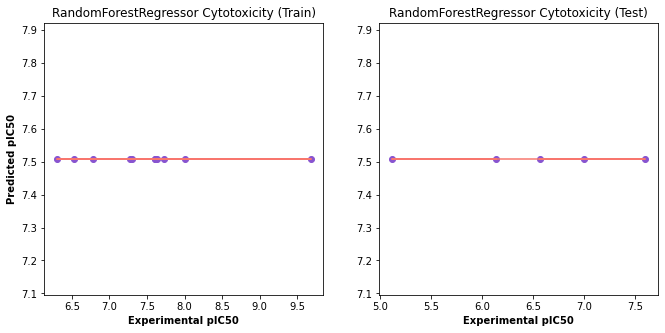

In [22]:
rfr_y_train_pred = rfr.predict(x_train)
rfr_y_test_pred = rfr.predict(x_test)

# Mean square error
mse_rfr_train = mean_squared_error(y_train, rfr_y_train_pred)
mse_rfr_test = mean_squared_error(y_test, rfr_y_test_pred)

# R2 score
r2_rfr_test = r2_score(y_test, rfr_y_test_pred)
r2_rfr_train = r2_score(y_train, rfr_y_train_pred)

print(f"MSE (Train): {mse_rfr_train}")
print(f"MSE (Test): {mse_rfr_test}\n")

print(f"R2 Score (Train): {r2_rfr_train}")
print(f"R2 Score (Test): {r2_rfr_test}")

plt.figure(figsize=(11,5))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=y_train, y=rfr_y_train_pred, c="#8854d0")

z = np.polyfit(y_train, rfr_y_train_pred, 1)
p = np.poly1d(z)
plt.plot(y_train,p(y_train),"#F8766D")
plt.title("RandomForestRegressor Cytotoxicity (Train)", fontsize='large')
plt.ylabel('Predicted pIC50', fontweight='bold')
plt.xlabel('Experimental pIC50', fontweight='bold')

# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)
plt.scatter(x=y_test, y=rfr_y_test_pred, c="#8854d0")

z = np.polyfit(y_test, rfr_y_test_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test),"#F8766D")
plt.title("RandomForestRegressor Cytotoxicity (Test)", fontsize='large')
plt.xlabel('Experimental pIC50', fontweight='bold')
plt.show()

MSE (Train): 0.7733848556110359
MSE (Test): 1.3564847894881424

R2 Score (Train): -0.05434995339405502
R2 Score (Test): -0.9294855493782317


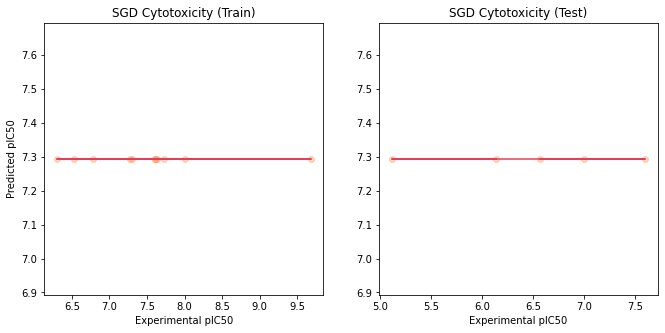

In [23]:
sgd_y_train_pred = sgd.predict(x_train)
sgd_y_test_pred = sgd.predict(x_test)

# Mean square error
mse_sgd_train = mean_squared_error(y_train, sgd_y_train_pred)
mse_sgd_test = mean_squared_error(y_test, sgd_y_test_pred)

# R2 score
r2_sgd_test = r2_score(y_test, sgd_y_test_pred)
r2_sgd_train = r2_score(y_train, sgd_y_train_pred)

print(f"MSE (Train): {mse_sgd_train}")
print(f"MSE (Test): {mse_sgd_test}\n")

print(f"R2 Score (Train): {r2_sgd_train}")
print(f"R2 Score (Test): {r2_sgd_test}")

plt.figure(figsize=(11,5))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=y_train, y=sgd_y_train_pred, c="#fa8231", alpha=0.3)

z = np.polyfit(y_train, sgd_y_train_pred, 1)
p = np.poly1d(z)
plt.plot(y_train,p(y_train),"#eb3b5a")
plt.title("SGD Cytotoxicity (Train)")
plt.ylabel('Predicted pIC50')
plt.xlabel('Experimental pIC50')

# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)
plt.scatter(x=y_test, y=sgd_y_test_pred, c="#fa8231", alpha=0.3)

z = np.polyfit(y_test, sgd_y_test_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test),"#eb3b5a")
plt.title("SGD Cytotoxicity (Test)")
plt.xlabel('Experimental pIC50')
plt.show()

MSE (Train): 1.9969628519122913
MSE (Test): 6.324736798132109

R2 Score (Train): -1.7224449438951996
R2 Score (Test): -7.99640626285351


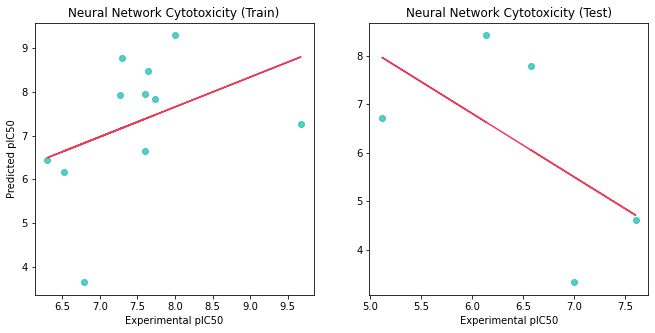

In [24]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

nn_y_train_pred = np.array(y_train_pred).reshape(y_train.shape)
nn_y_test_pred = np.array(y_test_pred).reshape(y_test.shape)

# Mean square error
mse_nn_train = mean_squared_error(y_train, nn_y_train_pred)
mse_nn_test = mean_squared_error(y_test, nn_y_test_pred)

# R2 score
r2_nn_test = r2_score(y_test, nn_y_test_pred)
r2_nn_train = r2_score(y_train, nn_y_train_pred)

print(f"MSE (Train): {mse_nn_train}")
print(f"MSE (Test): {mse_nn_test}\n")

print(f"R2 Score (Train): {r2_nn_train}")
print(f"R2 Score (Test): {r2_nn_test}")

plt.figure(figsize=(11,5))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=y_train, y=nn_y_train_pred, c="#0fb9b1", alpha=0.7)

z = np.polyfit(y_train, nn_y_train_pred, 1)
p = np.poly1d(z)
plt.plot(y_train,p(y_train),"#eb3b5a")
plt.title("Neural Network Cytotoxicity (Train)")
plt.ylabel('Predicted pIC50')
plt.xlabel('Experimental pIC50')

# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)
plt.scatter(x=y_test, y=nn_y_test_pred, c="#0fb9b1", alpha=0.7)

z = np.polyfit(y_test, nn_y_test_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test),"#eb3b5a")
plt.title("Neural Network Cytotoxicity (Test)")
plt.xlabel('Experimental pIC50')
plt.show()

In [25]:
ml_result = pd.DataFrame()

ml_result['type'] = ["Train", "Test", "Train", "Test", "Train", "Test"]
ml_result['mse'] = [mse_nn_train, mse_nn_test, mse_sgd_train, mse_sgd_test, mse_rfr_train, mse_rfr_test]
ml_result['r2score'] = [r2_nn_train, r2_nn_test, r2_sgd_train, r2_sgd_test, r2_rfr_train, r2_rfr_test]
ml_result['model'] = ["NeuralNetwork", "NeuralNetwork", "SGDRegressor", "SGDRegressor", "RandomForestRegressor", "RandomForestRegressor"]

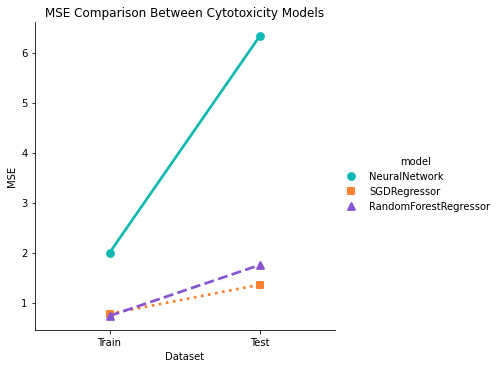

In [26]:
sns.catplot(x="type", 
            y="mse", 
            hue="model", 
            kind="point", 
            palette={"NeuralNetwork": "#0fb9b1", 
                     "SGDRegressor": "#fa8231", 
                     "RandomForestRegressor": "#8854d0"},
            markers=["o", "s", "^"], 
            linestyles=["solid", "dotted", "dashed"],
            data=ml_result)
plt.title("MSE Comparison Between Cytotoxicity Models")
plt.xlabel('Dataset')
plt.ylabel('MSE')
plt.show()

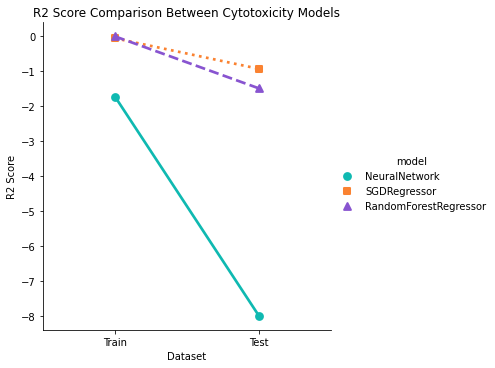

In [27]:
sns.catplot(x="type", 
            y="r2score", 
            hue="model", 
            kind="point", 
            palette={"NeuralNetwork": "#0fb9b1", 
                     "SGDRegressor": "#fa8231", 
                     "RandomForestRegressor": "#8854d0"},
            markers=["o", "s", "^"], 
            linestyles=["solid", "dotted", "dashed"],
            data=ml_result)

plt.title("R2 Score Comparison Between Cytotoxicity Models")
plt.xlabel('Dataset')
plt.ylabel('R2 Score')
plt.show()